In [1]:
%matplotlib inline
# import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# import videoUtility
import numpy.linalg as la
import scipy.io

import sys

# import sparsify
import sparsify_PyTorch
import utility

import torch
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor
from torch.utils.data import DataLoader, Dataset


In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

dataset_size = 1000
# take first <dataset_size> images as a demo dataset
images = training_data.data[:dataset_size] # <dataset_size> x 28 x 28


/home/derek/anaconda3/envs/py11-torch2-cuda/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


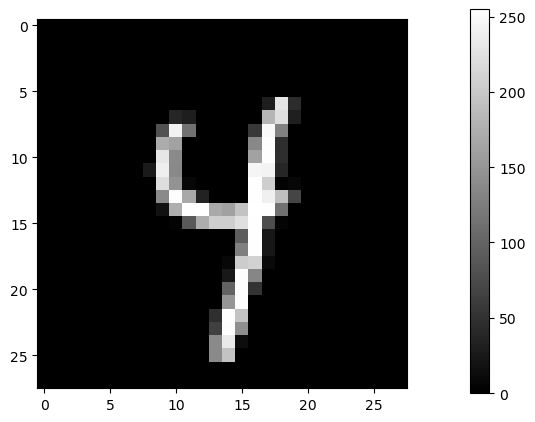

In [3]:
utility.imshow(images[26,:,:])

In [4]:
torch.cuda.set_device(0) #use GPU 1
# Now let's start to learn sparse coding basis
# Effective dimensionality is about 200, let's make it 20 times overcomplete.
# Layer1 sparse coding initialization

xdim = 6 #Patch size
ydim = 6 #Patch size
BASIS1_NUM = 500
BASIS1_SIZE = [xdim*ydim, BASIS1_NUM]
BATCH_SIZE = 20

basis1 = torch.randn(BASIS1_SIZE).cuda()
basis1.div_(basis1.norm(2,0)) # so every base vector's norm = 1

lambd = 1.0
STEPS = 30000

ACT_HISTORY_LEN = 300
HessianDiag = torch.zeros(BASIS1_NUM).cuda()
ActL1 = torch.zeros(BASIS1_NUM).cuda()
signalEnergy = 0.
noiseEnergy = 0.

edgeBuff = 2
spRange_t = images.shape[0]
spRange_x = images.shape[1] - xdim - edgeBuff * 2
spRange_y = images.shape[2] - ydim - edgeBuff * 2
I = np.zeros([xdim*ydim,BATCH_SIZE]).astype('int')
totalSteps1 = 0

In [5]:
for i in range(totalSteps1,STEPS):
    for j in range(BATCH_SIZE):
        sIdx = np.floor(np.random.rand()*spRange_t).astype(int)
        xIdx = np.floor(np.random.rand()*spRange_x + edgeBuff).astype(int)
        yIdx = np.floor(np.random.rand()*spRange_y + edgeBuff).astype(int)
        I[:,j] = images[sIdx,xIdx:xIdx+xdim,yIdx:yIdx+ydim].reshape([xdim*ydim])
    I_cuda = torch.from_numpy(I).cuda()
    
    #Sparse Coefficients Inference by ISTA
    #For positive-only codes, use ISTA
    #For positive-negative codes, use ISTA_PN 
    ahat, Res = sparsify_PyTorch.ISTA_PN(I_cuda, basis1, lambd, 1000)
    #ahat, Res = sparsify_PyTorch.ISTA(I_cuda, basis1, 0.03, 1000)
    
    #Statistics Collection
    ActL1 = ActL1.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + ahat.abs().mean(1)/ACT_HISTORY_LEN
    HessianDiag = HessianDiag.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(ahat,2).mean(1)/ACT_HISTORY_LEN
    
    signalEnergy = signalEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(I_cuda,2).sum()/ACT_HISTORY_LEN
    noiseEnergy = noiseEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(Res,2).sum()/ACT_HISTORY_LEN
    snr = signalEnergy/noiseEnergy
    
    #Dictionary Update
    totalSteps1 = totalSteps1 + 1
    basis1 = sparsify_PyTorch.quadraticBasisUpdate(basis1, Res, ahat, 0.001, HessianDiag, 0.01)
    
    #Print Information
    if i % 100 == 0:
        print(totalSteps1, snr, HessianDiag.min(), HessianDiag.max(), ActL1.min(), ActL1.max(), ActL1.sum())

/home/derek/Documents/WarnUp/Sparse-Coding/sparsify_PyTorch.py:50: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/tensor/python_tensor.cpp:83.)
  Res = torch.cuda.FloatTensor(I.size()).fill_(0)


1 tensor(46905.2812, device='cuda:0') tensor(0., device='cuda:0') tensor(7.2777, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1120, device='cuda:0') tensor(7.2543, device='cuda:0')
101 tensor(37166.9023, device='cuda:0') tensor(7.8287, device='cuda:0') tensor(15.8886, device='cuda:0') tensor(0.6460, device='cuda:0') tensor(0.9574, device='cuda:0') tensor(405.0724, device='cuda:0')
201 tensor(37060.3633, device='cuda:0') tensor(12.8784, device='cuda:0') tensor(26.7184, device='cuda:0') tensor(1.1512, device='cuda:0') tensor(1.5036, device='cuda:0') tensor(671.8064, device='cuda:0')
301 tensor(36848.6992, device='cuda:0') tensor(17.1328, device='cuda:0') tensor(35.9070, device='cuda:0') tensor(1.5284, device='cuda:0') tensor(1.9293, device='cuda:0') tensor(854.2417, device='cuda:0')
401 tensor(37016.5039, device='cuda:0') tensor(20.3727, device='cuda:0') tensor(42.9685, device='cuda:0') tensor(1.8133, device='cuda:0') tensor(2.2788, device='cuda:0') tensor(995.7990, device='cuda

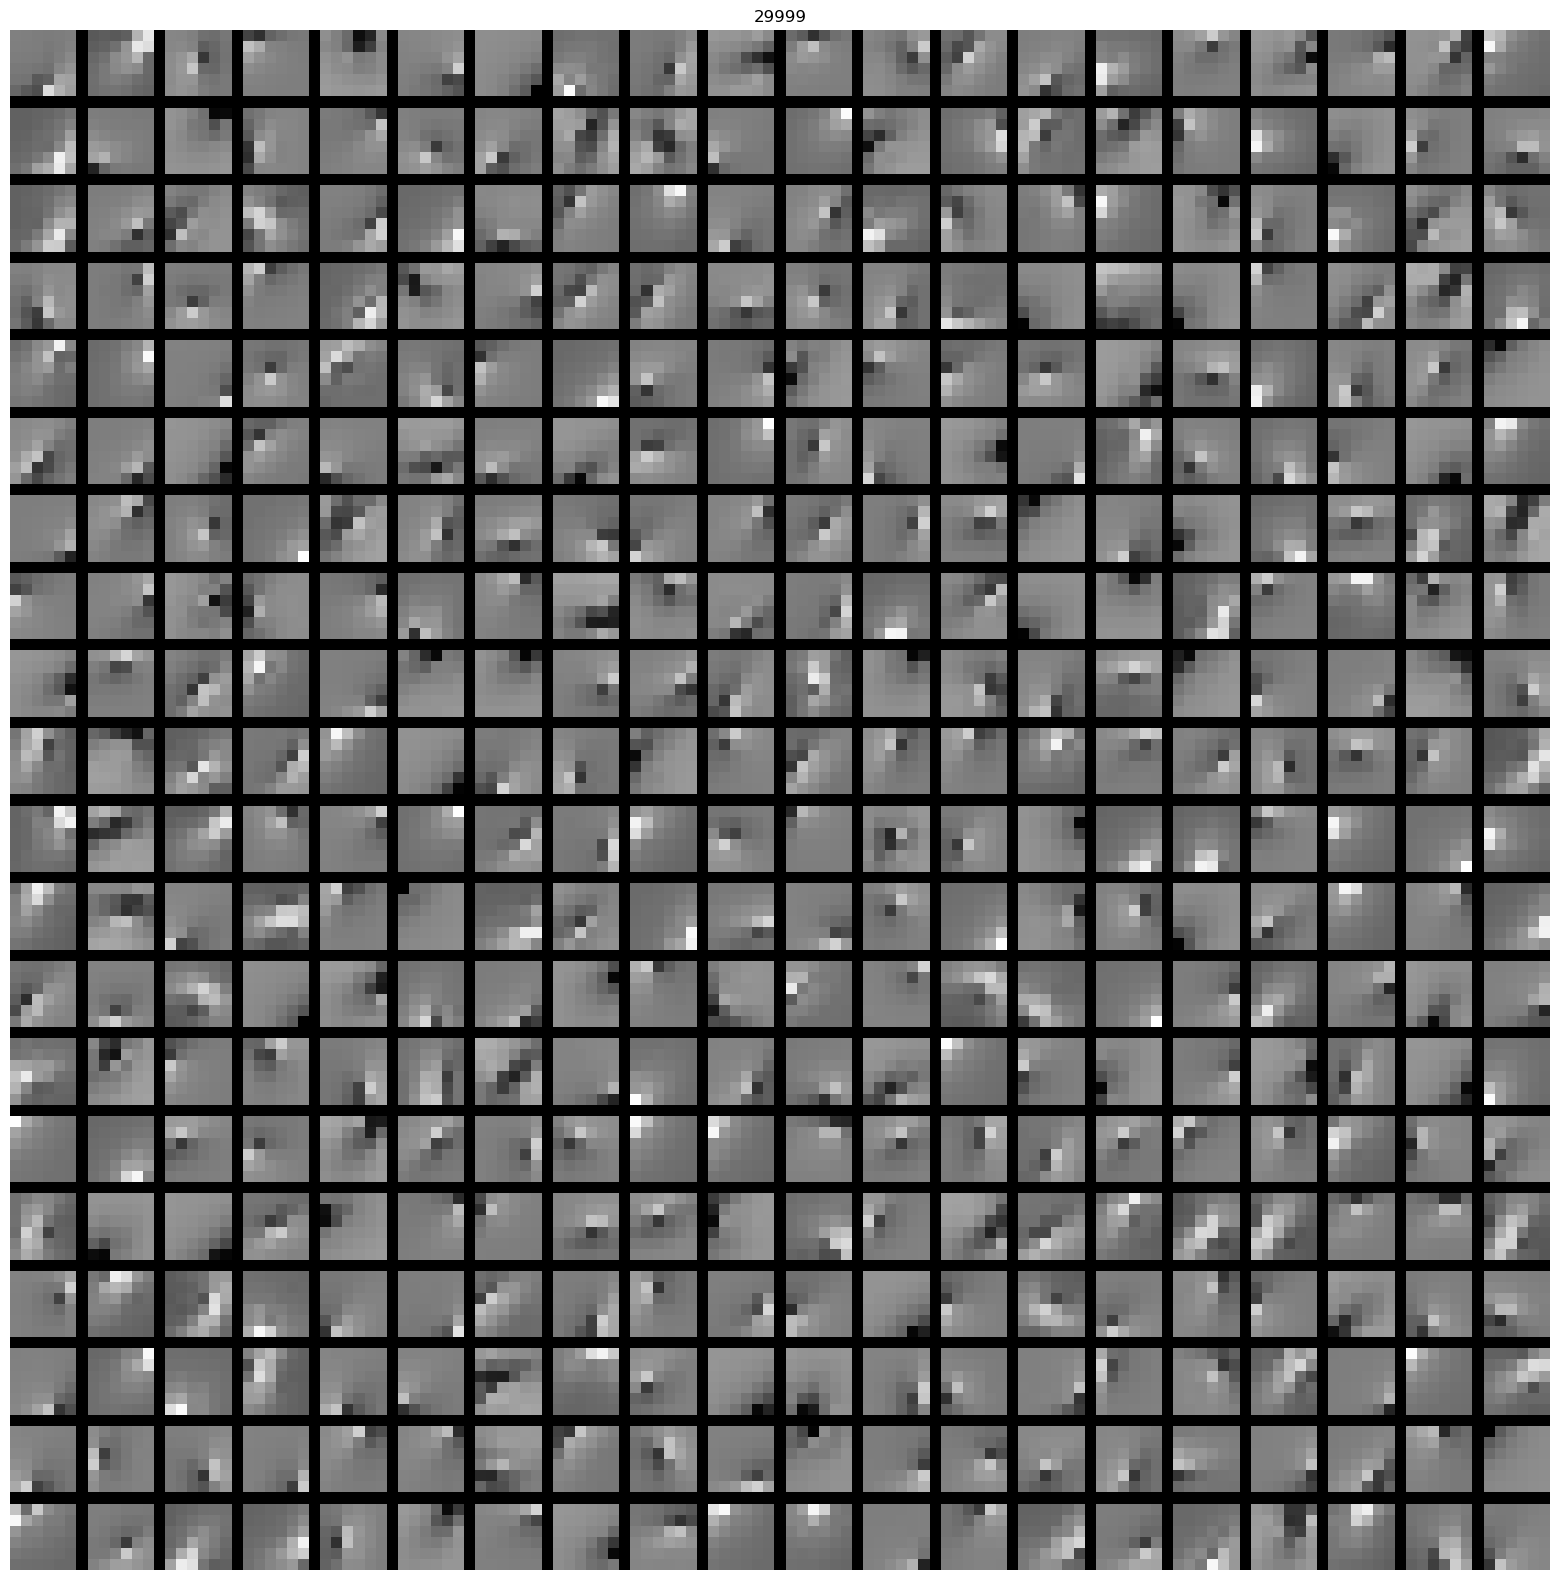

In [9]:
#Dictionary Visualization
basis1_host = basis1.cpu().numpy()
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
utility.displayVecArry(basis1_host,20,20,ax=ax,title=i,equal_contrast=True) #Visualize first 400 Dictionary Elements

In [10]:
# np.savez("basis1_IMAGES_Vanhateren_10x.npz", basis1 = basis1_host)

(36, 500)

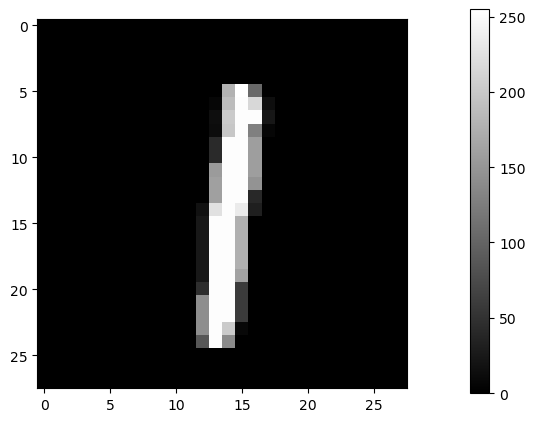

In [11]:
image_idx = 40
image = images[image_idx,:,:]
utility.imshow(image)

# find sparse code 
basis1_host.shape


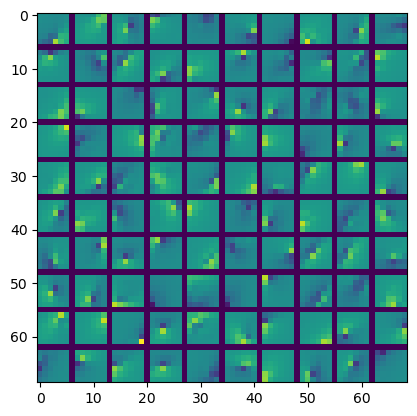